In [1]:
import torch
import torch.nn.functional as F
from models import E_2d, PE, BlockMLP
from kornia.utils.grid import create_meshgrid
from einops import rearrange, reduce, repeat
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import time
import numpy as np
from metrics import psnr


device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size = (4096, 4096)
patch_size = (32, 32)
n_scales = 4
n_layers = 3
n_hidden = 20
exp_name = f'pluto4k_{n_scales}scale'

n_freq = 4
P = torch.cat([E_2d*2**i for i in range(n_freq)], 1)
pe = PE(P).to(device)

uv = create_meshgrid(patch_size[1], patch_size[0], device=device)

rgb_gt = np.float32(Image.open('images/pluto.png').convert('RGB'))/255.
rgb_gt = rearrange(rgb_gt, 'h w c -> 1 c h w')
rgb_gt = F.interpolate(torch.from_numpy(rgb_gt),
                       size=input_size,
                       mode='bilinear',
                       align_corners=True)
rgb_gt = rearrange(rgb_gt, '1 c h w -> h w c').numpy()

/home/ubuntu/anaconda3/envs/pl/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
t = time.time()
for j in reversed(range(n_scales)):
    final_act = 'sigmoid' if j==n_scales-1 else 'sin'
    nh = input_size[1]//(patch_size[1]*2**j)
    nw = input_size[0]//(patch_size[0]*2**j)
    ckpt = torch.load(f'ckpts/{exp_name}/l{j}.ckpt', map_location=torch.device('cpu'))
    active_blocks = ckpt['active_blocks']
    n_blocks = int(active_blocks.sum())
    blockmlp = BlockMLP(n_blocks=n_blocks,
                        n_in=pe.out_dim, n_out=3,
                        n_layers=n_layers,
                        n_hidden=n_hidden,
                        final_act=final_act).to(device=device)
    blockmlp.load_state_dict(ckpt, strict=False)

    uv_ = repeat(uv, '1 ph pw c -> n (ph pw) c', n=n_blocks)
    with torch.no_grad():
        rgb_pred_ = blockmlp(uv_, **{'pe': pe, 'to_cpu': True})
        if j <= n_scales-2:
            rgb_pred_ *= ckpt['scales']
    torch.cuda.synchronize()

    rgb_pred = torch.zeros(nh*nw, patch_size[1]*patch_size[0], 3)
    rgb_pred[active_blocks] = rgb_pred_
    rgb_pred = rearrange(rgb_pred,
                         '(nh nw) (ph pw) c -> (nh ph) (nw pw) c',
                         nh=nh, nw=nw, ph=patch_size[1], pw=patch_size[0])
    if j <= n_scales-2:
        rgb_pred += I_j_u
        rgb_pred = np.clip(rgb_pred, 0, 1)

    if j > 0:
        I_j_u = F.interpolate(rearrange(rgb_pred, 'h w c -> 1 c h w'),
                              mode='bilinear',
                              scale_factor=2,
                              align_corners=True)
        I_j_u = rearrange(I_j_u, '1 c h w -> h w c')
torch.cuda.empty_cache()

rgb_pred = rgb_pred.numpy()
print(f'total time {time.time()-t:.3f} s')
print(f'PSNR {psnr(rgb_pred, rgb_gt):.4f} dB')
del I_j_u, ckpt, active_blocks, blockmlp, P, pe, uv, uv_

total time 1.908 s
PSNR 42.2352 dB


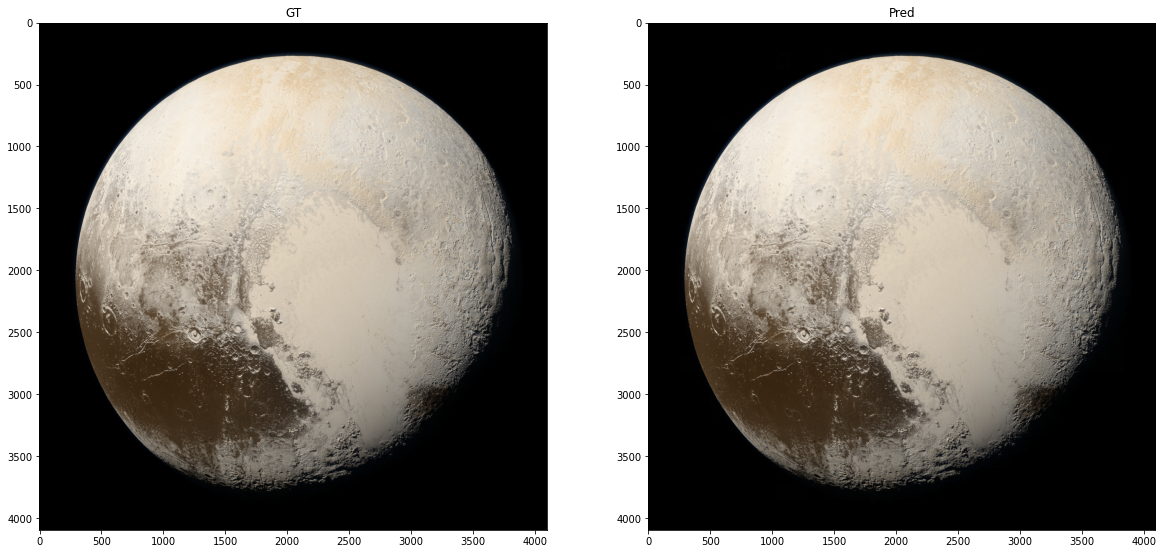

In [3]:
plt.subplots(figsize=(20, 20))
plt.subplot(121)
plt.title('GT')
plt.imshow(rgb_gt)
plt.subplot(122)
plt.title('Pred')
plt.imshow(rgb_pred);

# Visualize block decomposition

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


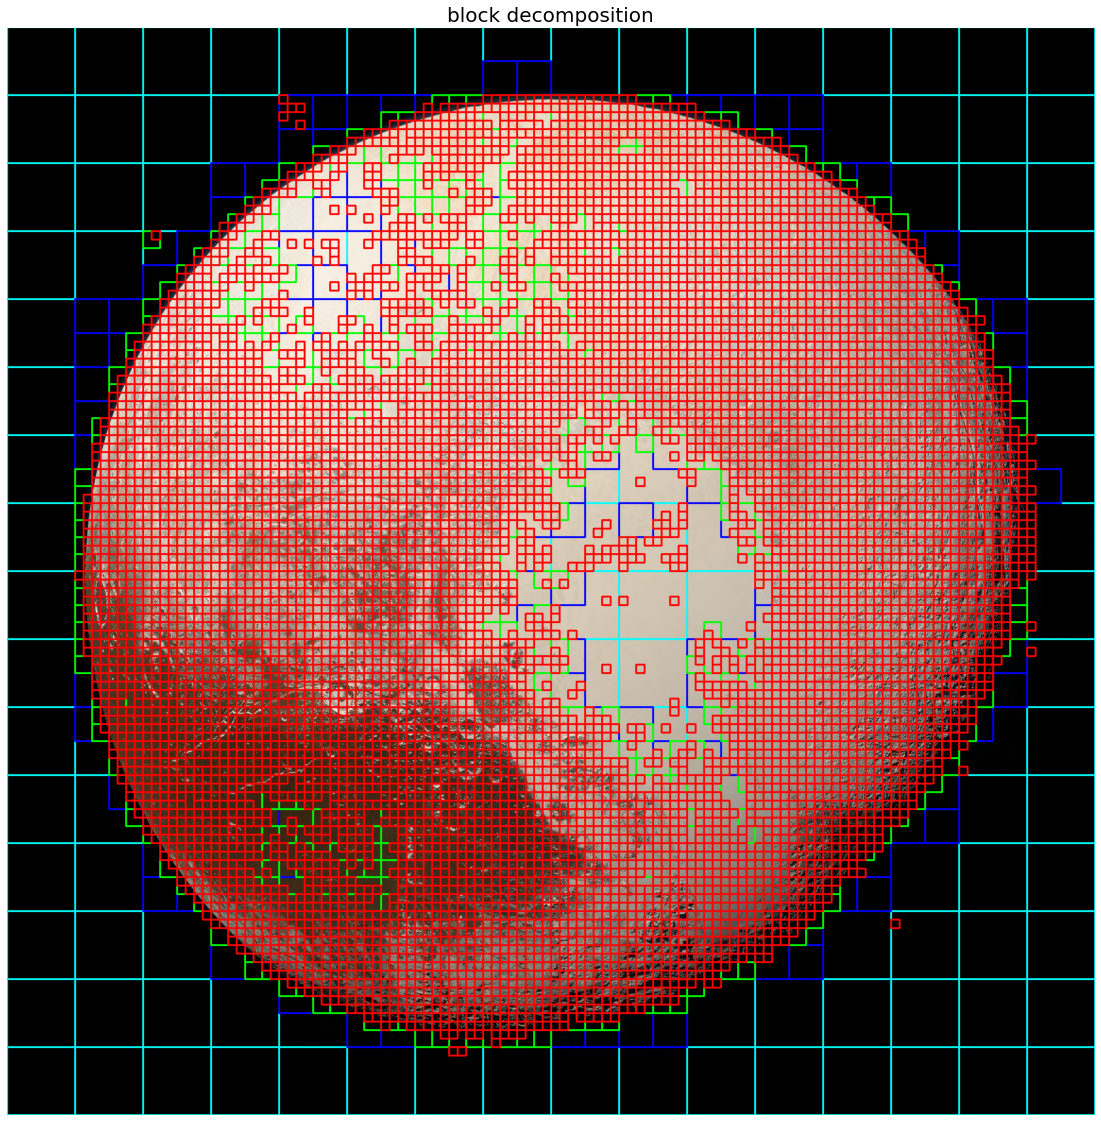

In [4]:
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255),
          (0, 255, 255), (255, 0, 255), (255, 255, 0)] # colors for each scale

image_ = rgb_pred.copy()
for l in reversed(range(n_scales)):
    rw, rh = patch_size[0]*2**l, patch_size[1]*2**l
    ckpt = torch.load(f'ckpts/{exp_name}/l{l}.ckpt', map_location=torch.device('cpu'))
    training_blocks = np.ones((input_size[1]//rh, input_size[0]//rw), bool)
    active_blocks = ckpt['active_blocks'].numpy().reshape(input_size[1]//rh, input_size[0]//rw)
    training_blocks[active_blocks] = 0 # converged

    for j in range(training_blocks.shape[0]):
        for i in range(training_blocks.shape[1]):
            if not training_blocks[j, i]:
                cv2.rectangle(image_, (i*rw, j*rh), ((i+1)*rw, (j+1)*rh), COLORS[l],
                              int(np.ceil(max(input_size)/1000)))

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.title('block decomposition', fontsize=20)
plt.imshow(image_);